In [2]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [3]:
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
#skmultiflow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeRegressor
#scikit 
from scipy.spatial import distance_matrix
from scipy.spatial import distance
#graph
import networkx as nx
#ontology
import owlready2 as owl
#language model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#dunn index
import dunn
from sklearn.metrics.pairwise import euclidean_distances
#other
from copy import deepcopy
from itertools import count
from joblib import dump, load
from joblib import Parallel, delayed
import datetime

import warnings
warnings.filterwarnings("ignore")

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from gym import spaces

In [6]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

helping functions

In [7]:
def flatten_list(list1):
    out = []
    inside = list1
    while inside:
        x = inside.pop(0)
        if isinstance(x, list):
            inside[0:0] = x
        else:
            out.append(x)
    return out

In [8]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [9]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=60):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [10]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=3)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [11]:
def find_objects2(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(2))

    # label image regions
    label_image = label(reg)
    
    return label_image

In [12]:
def find_objects3(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    #0.327
    # label image regions
    label_image = label(img > thresh)
    
    return label_image

In [13]:
def find_objects(image):
    img = rgb2gray(image)

    # label image regions
    label_image = label(img > 0.327)
    
    return label_image

In [14]:
def find_cut_objects(image,m_h,m_w,grayscale=True):
    label_image=find_objects(image)
    regions=regionprops(label_image)

    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxc-minc)/m_w))!=1:
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][:,split_w[y]:split_w[y+1]][reg.image[:,split_w[y]:split_w[y+1]]]=i
    
    regions=regionprops(label_image)
    i=len(regions)+1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],:][reg.image[split_h[x]:split_h[x+1],:]]=i


    regions=regionprops(label_image)
    
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [15]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    if prox==0:
        dist=np.zeros((len(centroids),len(centroids)))
    else:
        dist=distance_matrix(centroids,centroids)
        dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:int(centroids[x][0]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:int(centroids[x][1]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

In [16]:
def graph_to_doc(Graphs,iterations=2,start_tag=0):
    documents=[]
    hashes=None
    for i in range(len(Graphs)):
        if iterations>0:
            hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
            
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[
                    Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"]),
                     Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                     "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     "pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"])                   
                    ]
            if iterations>0:
                Doc=Doc+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [17]:
def graph_to_doc2(Graphs,iterations=2,start_tag=0):
    documents=[]
    hashes=None
    for i in range(len(Graphs)):
        if iterations>0:
            hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
            
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                    Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"]),
                     Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                     "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     "pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"])                   
                    ]
            if iterations>0:
                Doc=Doc+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [18]:
def doc_to_embedding(documents,model,seed=42):
    model.random.seed(seed)
    return np.array([model.infer_vector(doc) for doc in documents])

In [19]:
def visualize_graph(g,max_col=15):
    nodes = g.nodes()
    colors = [int(g.nodes[n]['feature'])/max_col for n in nodes]
    pos = nx.spring_layout(g)
    for n in nodes:
        pos[n][1]=-1*g.nodes[n]['position_x']
        pos[n][0]=g.nodes[n]['position_y']

    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=150, cmap=plt.cm.jet,vmin=0,vmax=1)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [20]:
def graph_diff2(G1,G2,obj_class_diff=100,obj_n_diff=100):
    n1=set([(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes])
    n2=set([(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes])
    l1=list(n1.difference(n2))
    l2=list(n2.difference(n1))
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [21]:
def node_dist2(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+abs(n1[1]-n2[1])+abs(n1[2]-n2[2])

In [22]:
def node_dist(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+np.sqrt((n1[1]-n2[1])**2+(n1[2]-n2[2])**2)

In [23]:
def graph_metric(dist,obj_n_diff=100):
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [24]:
def graph_diff(G1,G2,obj_class_diff=100,obj_n_diff=100):
    l1=[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes]
    l2=[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes]
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [25]:
def graph_diff3(l1,l2,obj_class_diff=100,obj_n_diff=100):

    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    c1=np.array([[l[1],l[2]] for l in l1])
    c2=np.array([[l[1],l[2]] for l in l2])
    
    lab1=np.array([[int(l[0])] for l in l1])
    lab2=np.array([[int(l[0])] for l in l2])
    
    dist=euclidean_distances(c1,c2)+obj_class_diff*(euclidean_distances(lab1,lab2)>0)
        
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [26]:
def graph_diff_list(G1_list,G2_list,obj_class_diff=100,obj_n_diff=100):
    L1=[[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes] for G1 in G1_list]
    L2=[[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes] for G2 in G2_list]
    
    dist=np.zeros((len(L1),len(L2)))
    for x in range(len(L1)):
        for y in range(len(L2)):
            dist[x,y]=graph_diff3(L1[x],L2[y])
            if dist[x,y]==0:
                break
        
    return dist

In [27]:
def regions_to_embedding(regions,labels,grid,label_size=16,x=105,y=80,max_rad=10):
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,grid)
    dist=(1-np.clip(dist/max_rad,0,1))#**2
    emb=np.zeros((label_size+1,grid.shape[0]))
    emb[0,:]=dist.sum(axis=0)
    for lab in np.unique(labels):
        emb[lab+1,:]=dist[labels==lab,:].sum(axis=0)
        
    return emb

In [28]:
def make_grid(shape,x=2,y=2):
    grid=np.zeros((x*y,2))
    split_h=np.linspace(0,shape[0],y).astype("int")
    split_w=np.linspace(0,shape[1],x).astype("int")
    z=0
    for i in split_h:
        for j in split_w:
            grid[z,:]=[i,j]
            z+=1
    return grid

In [29]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<h3>Use Cuda</h3>

In [30]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [31]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Deep Q Network</h2>

In [32]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [33]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

<h2>Computing Temporal Difference Loss</h2>

In [34]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [35]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.plot(moving_average(rewards,10))
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<p><hr></p>

<h1>Atari Environment</h1>

<h2>Training</h2>

In [36]:
class PongRamEnvironment(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.repeat_action=4
        self.last_state=np.zeros(4)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(8,), dtype=np.float32)
        self.action_space=spaces.Discrete(3)
        
    def preprocess_state(self, state):
        #cpu_score = ram[13]  # computer/ai opponent score 
        #player_score = ram[14]  # your score
        cpu_paddle_y = state[21]  # Y coordinate of computer paddle
        player_paddle_y = state[51]  # Y coordinate of your paddle
        ball_x = state[49]  # X coordinate of ball
        ball_y = state[54]  # Y coordinate of ball
        obs = np.array([cpu_paddle_y, player_paddle_y, ball_x, ball_y], dtype=np.float32)/255.0
        return obs


    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        state = np.zeros((2,4))
        self.last_state=np.zeros(4)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3,2:0}[actions]
        total_reward=0
        next_state=np.zeros((2,4))
        for i in range(self.repeat_action):
            state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        state=self.preprocess_state(state)
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
        
        return next_state.reshape(-1), total_reward, terminal, info

In [37]:
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space=spaces.Discrete(3)
    
    def action(self, act):
        act={0:2,1:3,2:2}[act]
        return act

In [38]:
class SemanticEnvironment(gym.Wrapper):

    def __init__(self, base_env):
        gym.Wrapper.__init__(self, env)
        
        self.num_clusters_obj=8
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=8
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        self.repeat_action=4
        self.x_grid=8
        self.y_grid=8
        self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.max_rad=distance.euclidean([0,0],[105//self.x_grid,80//self.y_grid])
        #self.max_rad=80
        #self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.dimensions=(1+self.num_clusters_obj)*self.x_grid*self.y_grid
        self.last_state=None
        
        self.action_space=spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(2*self.dimensions,), dtype=np.float32)
        #self.example_objects={}
        #self.example_objects_pca={}
        
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.reward_list=[]
        self.action_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        
        self.lookback=250
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        #state = state[::2,::2][16:98,8:72]
        state = state[::2,::2]#[17:97,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((np.unique(X,axis=0),np.unique(X,axis=0))))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
                
        if use_embedding:
            embedding=regions_to_embedding(regions,labels,self.grid,label_size=self.num_clusters_obj,max_rad=self.max_rad).reshape(-1)
            
            #clip emmbeding
            embedding=np.clip(embedding,-2, 2)
        
        else:
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,embedding


    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)
        state = np.zeros((2,self.dimensions))
        self.last_state=np.zeros(self.dimensions)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3,2:0}[actions]
        
        total_reward=0
        next_state=np.zeros((2,self.dimensions))
        for i in range(self.repeat_action):
            orig_state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        if self.keep_state_list:
            self.state_list.append(orig_state.copy())
            self.reward_list.append(total_reward)
            self.action_list.append(actions)
        
        if self.keep_pca_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_embedding=False)
        elif self.keep_birch_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_embedding=False)
        else:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True)
       
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
         
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
       
        return next_state.reshape(-1), reward, terminal, info

In [39]:
class Semantic2Environment(gym.Wrapper):

    def __init__(self, base_env):
        gym.Wrapper.__init__(self, env)
        
        self.num_clusters_obj=10
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=8
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        self.repeat_action=4
        self.dimensions=128
        self.last_state=None
        
        self.action_space=spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(2*self.dimensions,), dtype=np.float32)
        #self.example_objects={}
        #self.example_objects_pca={}
        
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.reward_list=[]
        self.action_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        self.graph_list=[]
        self.document_list=[]
        
        self.lookback=250
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False
        self.keep_graph_list=False
        
        #semantic model
        self.prox=30
        self.hash_iterations=2
        self.starting_doc_len=30000
        self.start_tag=0
        self.min_count=2
        self.seed=42
        self.workers = 4
        self.epochs = 20
        self.learning_rate = 0.025
        self.window=16
        self.hs=1
        self.dm=0
        self.negative=0
        self.max_vocab_size=30000
        self.semantic_model=Doc2Vec(
            vector_size=self.dimensions,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            hs=self.hs,
            negative=self.negative,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            max_vocab_size=self.max_vocab_size,
            seed=self.seed
        )

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
        
    def train_semantic(self):
        Graphs=self.graph_list
        Doc_all=graph_to_doc(Graphs,iterations=self.hash_iterations,start_tag=0)
        
        documents = [
                TaggedDocument(words=doc, tags=[i])
                for i, doc in enumerate(Doc_all)
            ]
    
        self.document_list=documents
        self.semantic_model.build_vocab(documents)
        self.semantic_model.train(documents,total_examples=len(documents),epochs=self.semantic_model.epochs)
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        #state = state[::2,::2][16:98,8:72]
        state = state[::2,::2]#[17:97,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((np.unique(X,axis=0),np.unique(X,axis=0))))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
                
        if self.keep_graph_list and not use_embedding:
            graph=regions_to_graph(regions,labels,prox=self.prox)
            self.graph_list.append(graph.copy())
        
        if use_embedding:
            #make graph
            graph=regions_to_graph(regions,labels,prox=self.prox)
            
            doc=graph_to_doc([graph],iterations=self.hash_iterations,start_tag=0)
            
            #make embedding
            embedding=doc_to_embedding(doc,self.semantic_model,seed=42)

            #clip emmbeding
            embedding=np.clip(embedding,-2, 2)[0]
        
        else:
            graph=nx.DiGraph()
            
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,embedding


    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)
        state = np.zeros((2,self.dimensions))
        self.last_state=np.zeros(self.dimensions)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3,2:0}[actions]
        
        total_reward=0
        next_state=np.zeros((2,self.dimensions))
        for i in range(self.repeat_action):
            orig_state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        if self.keep_state_list:
            self.state_list.append(orig_state.copy())
            self.reward_list.append(total_reward)
            self.action_list.append(actions)
        
        if self.keep_pca_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_embedding=False)
        elif self.keep_birch_list:
            _,_,_,state=self.preprocess_state(orig_state, use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_embedding=False)
        elif self.keep_graph_list:
            _,_,_,state=self.preprocess_state(orig_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=False)
        else:
            _,_,_,state=self.preprocess_state(orig_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True)
       
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
         
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
                self.keep_graph_list=True
                
        
        if self.keep_graph_list and len(self.graph_list)>=self.starting_doc_len and self.keep_pca_list==False and self.keep_birch_list==False:
            print("Accumulated: "+str(len(self.graph_list))+" graphs")
            self.keep_graph_list=False
            self.train_semantic()
       
        return next_state.reshape(-1), reward, terminal, info

In [37]:
env=gym.make('PongNoFrameskip-v4')
env=Semantic2Environment(env)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [38]:
%%time
env.reset()
while env.keep_birch_list==True or env.keep_pca_list==True:
    act=random.choice([0,1,2])
    _,_,done,_=env.step(act)
    if done:
        state = env.reset()

PCA stable after 1077 steps with err=0.009799251422193563
Birch stable after 747 steps with acc=1.0
CPU times: user 9.66 s, sys: 1.9 ms, total: 9.67 s
Wall time: 9.67 s


In [39]:
%%time
env.reset()
while env.keep_birch_list==True or env.keep_pca_list==True or env.keep_graph_list==True:
    act=random.choice([0,1,2])
    _,_,done,_=env.step(act)
    if done:
        state = env.reset()

Accumulated: 30000 graphs
CPU times: user 7min 4s, sys: 7.61 s, total: 7min 11s
Wall time: 4min 55s


# load example run

In [40]:
States=np.load("Pong_Example_Run.npy")
Graphs=[]
Label_imgs=[]
emb=[]
for state in States:
    label_img,regions,labels,emmbedding=env.preprocess_state(state)
    Graphs.append(regions_to_graph(regions,labels,prox=env.prox))
    Label_imgs.append(label_img)
    emb.append(emmbedding)

# test Birch and PCA

In [41]:
env.pca_obj.explained_variance_ratio_.sum()

0.990014344492504

In [42]:
centers=env.pca_obj.inverse_transform(env.image_seg.subcluster_centers_).reshape(env.image_seg.subcluster_centers_.shape[0],10,8,1)

centers=centers[np.argsort(env.image_seg.subcluster_labels_)]

labels_s=np.sort(env.image_seg.subcluster_labels_)

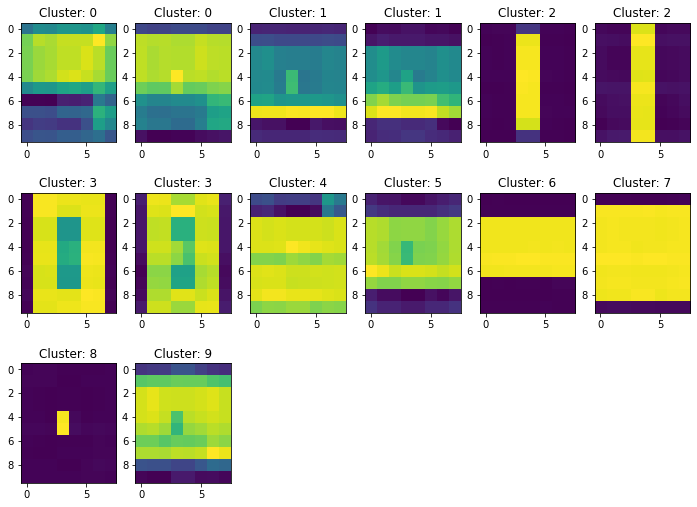

In [43]:
size=4
i=1
fig = plt.figure(figsize=(12,12))
for i in range(centers.shape[0]):
    fig.add_subplot(4, 6,i+1)
    plt.imshow(centers[i])
    plt.title("Cluster: "+str(labels_s[i]))
#     for k in range(4):
#         plt.title("Cluster: "+str(label))
#         fig.add_subplot(size, size,i)
#         plt.imshow(ob)
#         i+=1
plt.savefig('Pong_clusters.png')

In [44]:
len(env.birch_stab_acc)

497

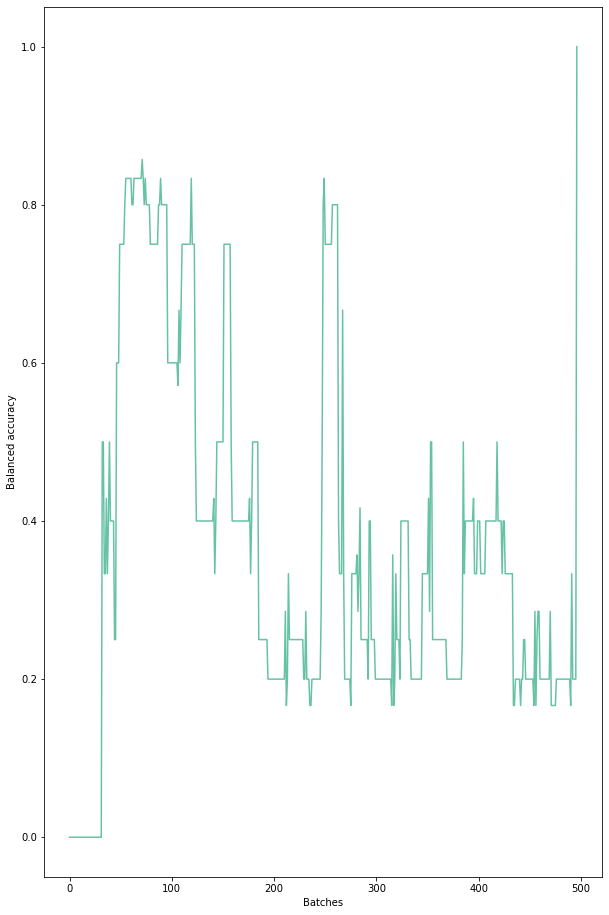

In [45]:
fig = plt.figure(figsize=(10,16))
sns.lineplot(x=np.arange(len(env.birch_stab_acc)),y=env.birch_stab_acc)
plt.xlabel("Batches")
plt.ylabel("Balanced accuracy")
plt.savefig('Pong_birch_stab.png')

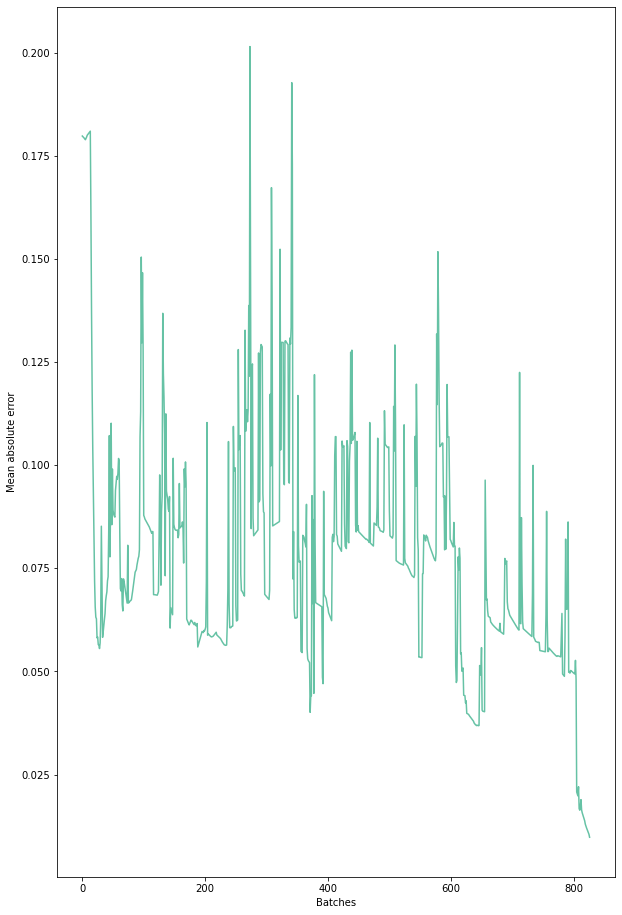

In [46]:
fig = plt.figure(figsize=(10,16))
sns.lineplot(x=np.arange(len(env.pca_stab_err)),y=env.pca_stab_err)
plt.xlabel("Batches")
plt.ylabel("Mean absolute error")
plt.savefig('Pong_pca_stab.png')

In [145]:
object_list=[]
for state in States:
    label_image, objects, regions=find_cut_objects(state[::2,::2],env.max_obj_height,env.max_obj_width)
    X=objects.reshape(objects.shape[0],-1)
    object_list.append(X.copy())

In [146]:
len(object_list)

1188

In [147]:
obj=object_list

obj=np.concatenate(obj)

In [148]:
obj.shape

(28976, 80)

In [149]:
obj=env.pca_obj.transform(obj)

lab=env.image_seg.predict(obj)

In [150]:
metrics.silhouette_score(obj, lab, metric='euclidean')

0.9427904766751632

In [151]:
metrics.davies_bouldin_score(obj, lab)

0.46745971938641195

In [152]:
d = euclidean_distances(obj[::10])

dunn.dunn(lab[::10],d)

0.5367384721756843

In [153]:
np.unique(lab)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [155]:
df = pd.DataFrame(np.concatenate((obj[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
df["z"]=df["z"].astype("int").astype("str")

df["z"]=df["z"].astype("int")

df=df.sort_values(["z"])

df["Class"]=df["z"].astype("str")

In [156]:
#sns.set_palette("Paired")

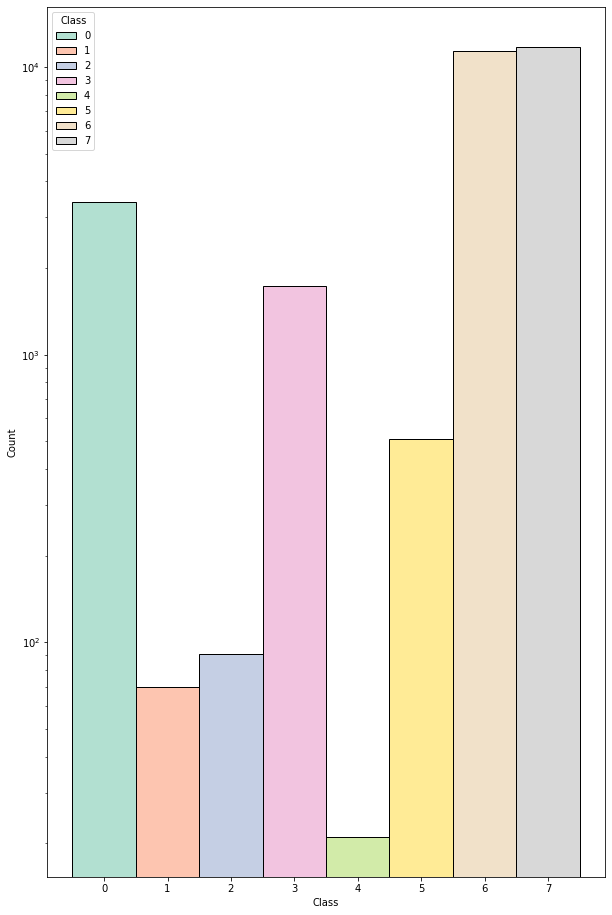

In [157]:
fig = plt.figure(figsize=(10,16))
sns.histplot(data=df,x="Class",hue="Class").set_yscale("log")
plt.savefig('Pong_hist.png')

In [158]:
df3=df

df4=df3.groupby(["x","y","Class"]).count()

df5=df4.groupby(["Class"]).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df5["size"]=df5["z"]

df5["Class"]=df5["Class"].astype("int")

df5=df5.sort_values(["Class"])

df5["Class"]=df5["Class"].astype("str")

df6=df5.loc[df5["size"]>2]

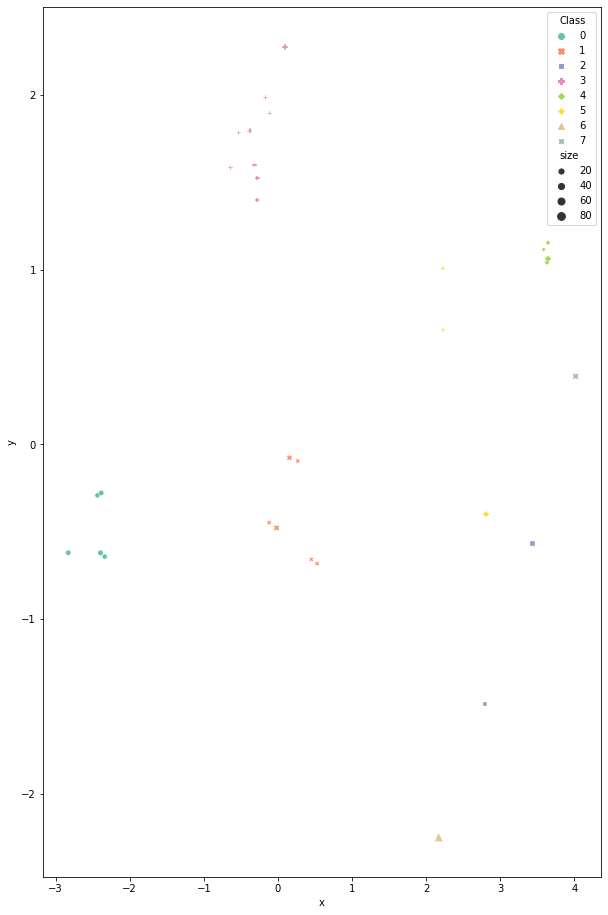

In [159]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(data=df6,x="x",y="y",hue="Class",style="Class",size="size")
plt.savefig('Pong_scatter_size.png')

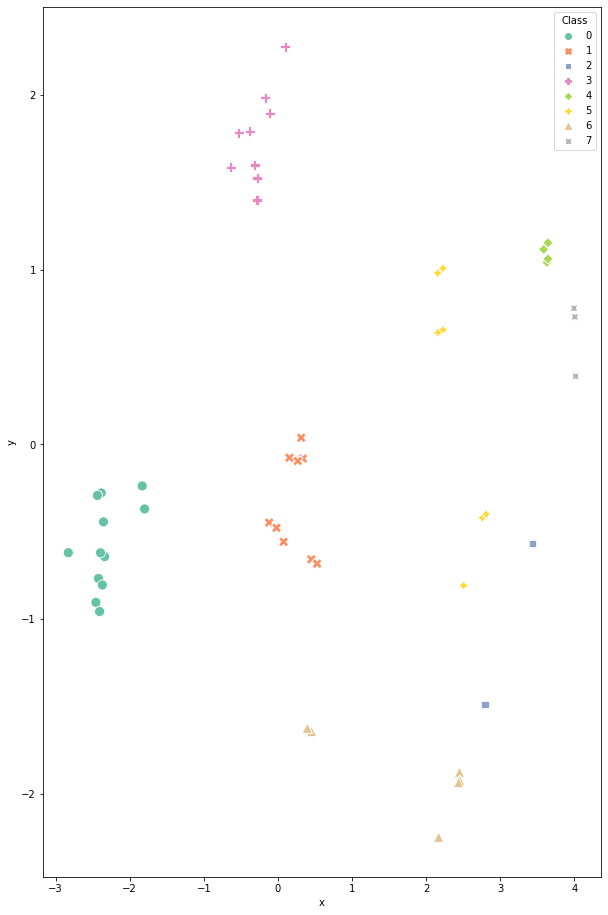

In [160]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(data=df,x="x",y="y",hue="Class",style="Class",s=100)
plt.savefig('Pong_scatter.png')

# Semantic embedding

In [47]:
%timeit _,_,_,emb=env.preprocess_state(States[100])

8.92 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
label_image,regions,labels,embedding=env.preprocess_state(States[100])

In [49]:
graph=regions_to_graph(regions,labels,prox=30)
            
doc=graph_to_doc([graph],iterations=2,start_tag=0)
            
embedding=doc_to_embedding(doc,env.semantic_model,seed=42)

In [54]:
%timeit graph=regions_to_graph(regions,labels,prox=20)

1.3 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
%timeit doc=graph_to_doc([graph],iterations=2,start_tag=0)

612 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [52]:
%timeit embedding=doc_to_embedding(doc,env.semantic_model,seed=42)

4.29 ms ± 65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
train_corpus=env.document_list
model=env.semantic_model

In [55]:
%%time
ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=1)
    ranks.append(sims[0][0])

CPU times: user 11min 20s, sys: 22min 6s, total: 33min 27s
Wall time: 4min 13s


In [56]:
similiar=np.array([x==ranks[x] for x in range(len(ranks))])

similiar.mean()

0.7067333333333333

In [57]:
wrong=np.argwhere(similiar==False)

g_diff=np.array([graph_diff(env.graph_list[ranks[w[0]]],env.graph_list[w[0]]) for w in wrong])

g_diff2=np.array([graph_diff(env.graph_list[ranks[w]],env.graph_list[w]) for w in range(len(ranks))])

In [58]:
(g_diff2==0).mean()

0.9275333333333333

In [59]:
similiar.mean()+(1-similiar.mean())*(g_diff==0).mean()

0.9275333333333333

In [60]:
similiar.mean()+(1-similiar.mean())*(g_diff<5).mean()

0.9964666666666666

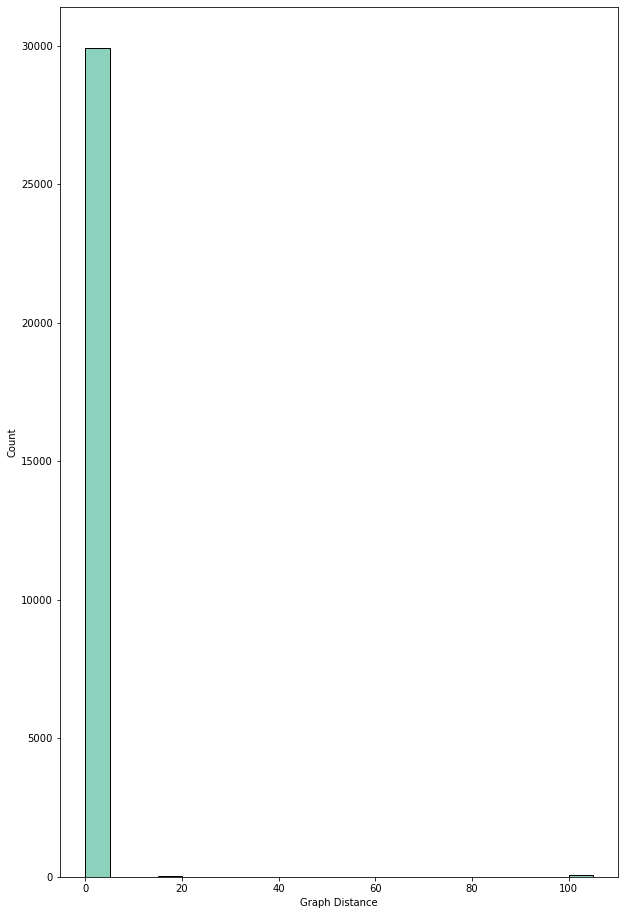

In [61]:
fig = plt.figure(figsize=(10,16))
sns.histplot(g_diff2,binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_train_hist.png')

In [62]:
worst=np.argmax(g_diff)

G1=env.graph_list[ranks[wrong[worst][0]]]

G2=env.graph_list[wrong[worst][0]]

graph_diff(G1,G2)

101.41421356237309

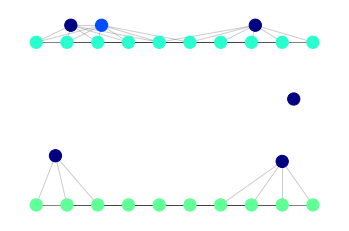

In [94]:
visualize_graph(G1)

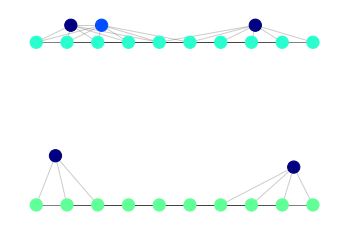

In [95]:
visualize_graph(G2)

In [63]:
ranks2=[]

for x in emb:
    sims = model.dv.most_similar([x], topn=1)
    ranks2.append(sims[0][0])

valid_diff=np.array([graph_diff(Graphs[i],env.graph_list[ranks2[i]]) for i in range(len(ranks2))])

In [64]:
np.mean(valid_diff<5)

0.6616161616161617

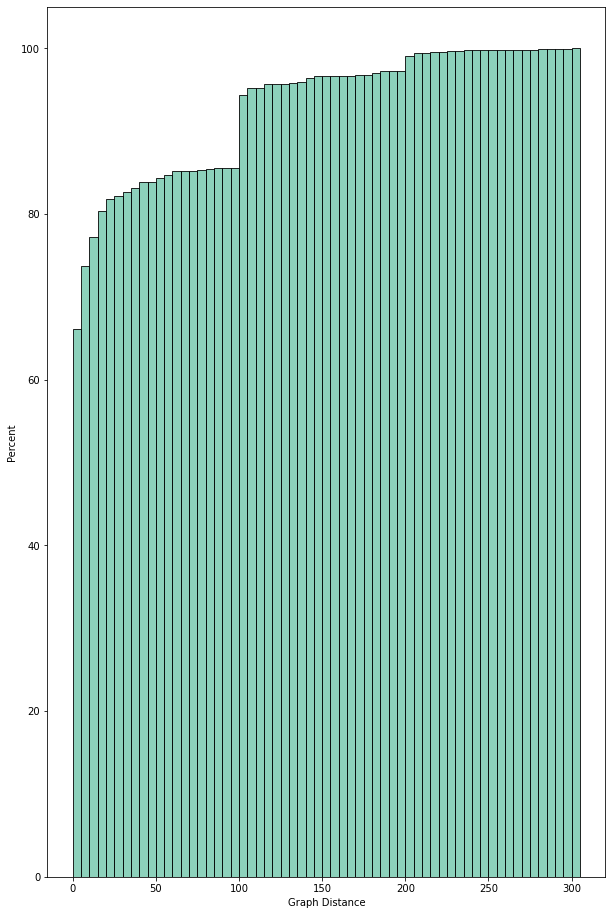

In [65]:
fig = plt.figure(figsize=(10,16))
sns.histplot(np.round(valid_diff,2),cumulative=True,stat="percent",binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

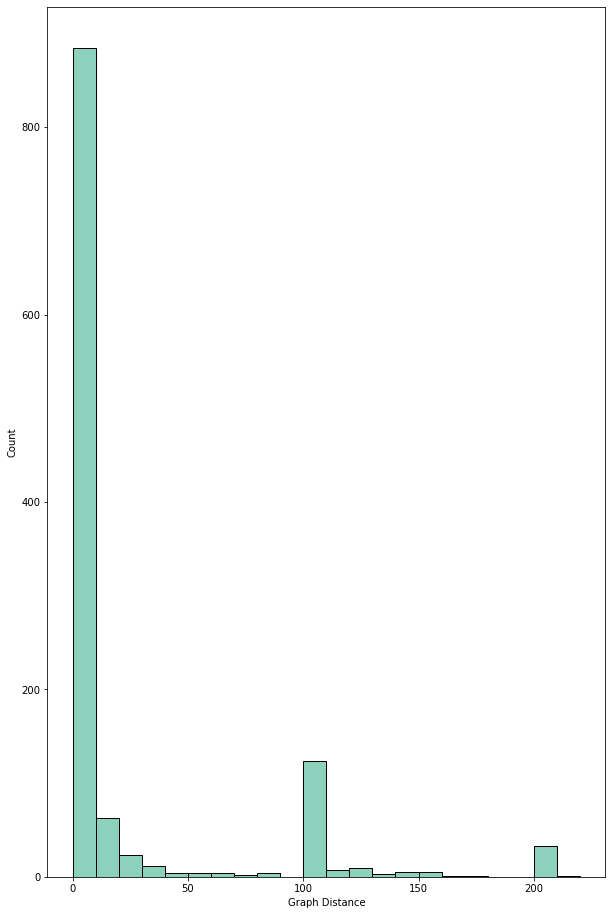

In [99]:
fig = plt.figure(figsize=(10,16))
sns.histplot(valid_diff,binwidth=10)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_hist.png')

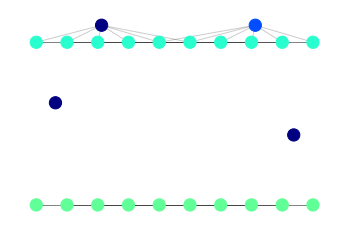

In [100]:
worst=np.argmax(valid_diff)

visualize_graph(env.graph_list[ranks2[worst]])

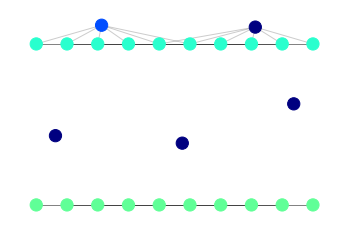

In [101]:
visualize_graph(Graphs[worst])

In [102]:
%%time
n_cores = 6
parallel = Parallel(n_jobs=n_cores)
results = parallel(delayed(graph_diff_list)(Graphs,env.graph_list[i::n_cores]) for i in range(n_cores))
#results=np.vstack(results).flatten()

CPU times: user 3.5 s, sys: 1.11 s, total: 4.61 s
Wall time: 1h 6min 55s


In [103]:
results2=np.hstack(results)

G_test2=np.min(results2,axis=1)

In [118]:
np.mean(valid_diff<5)/np.mean(G_test2<5)

0.7627118644067796

In [105]:
df_2=pd.DataFrame({"Distance":np.concatenate([valid_diff,G_test2]),"Embedding":np.concatenate([np.ones(len(valid_diff)),np.zeros(len(G_test2))])})

df_2["Embedding"]=df_2["Embedding"].astype("int")

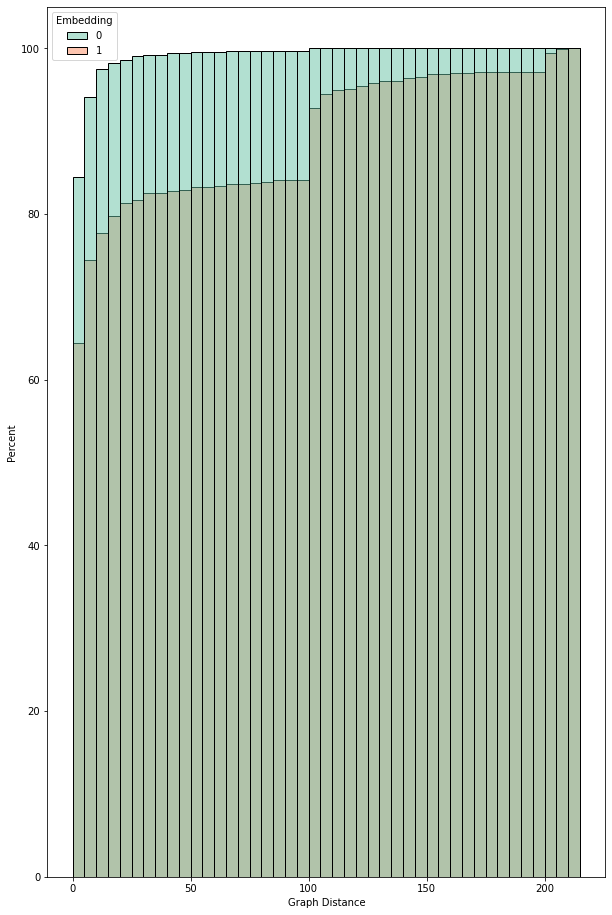

In [106]:
fig = plt.figure(figsize=(10,16))
sns.histplot(data=df_2,x="Distance",cumulative=True,stat="percent",hue="Embedding",common_norm=False,binwidth=5)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

In [107]:
def cosine_similarity(x, y):
    
    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None
    
    # Compute the dot product between x and y
    dot_product = np.dot(x, y)
    
    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.sqrt(np.sum(x**2)) 
    magnitude_y = np.sqrt(np.sum(y**2))
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)
    
    return cosine_similarity

In [108]:
X=np.array(emb)

changes=(np.abs(X[1:]-X[0:-1])).mean(axis=-1)

changes=np.array([cosine_similarity(X[i+1],X[i]) for i in range(len(Graphs)-1)])

G_diff=np.array([graph_diff(Graphs[i],Graphs[i+1]) for i in range(len(Graphs)-1)])

m, b = np.polyfit(changes, G_diff, 1)

np.min(changes)

-0.060873356

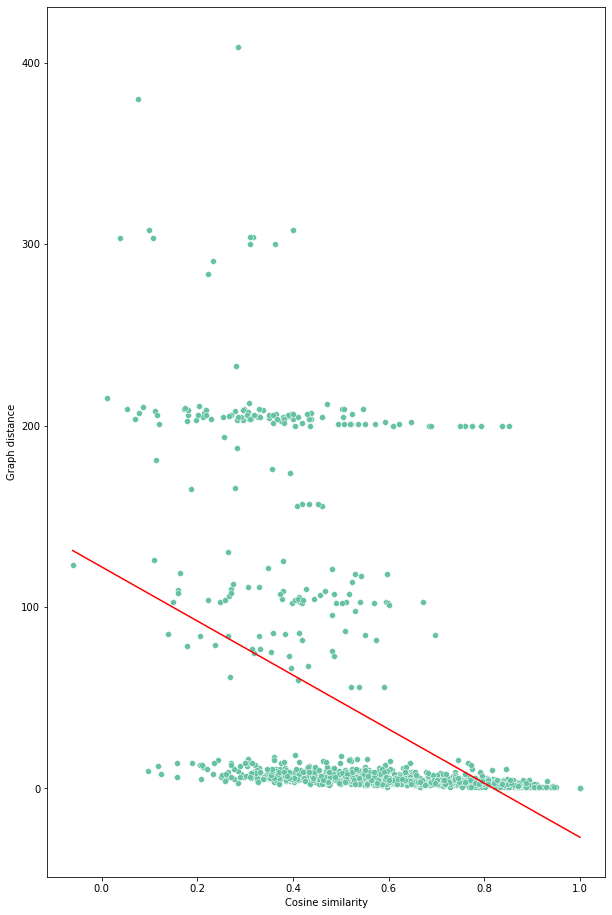

In [109]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(x=changes,y=G_diff)
plt.plot([np.min(changes),np.max(changes)], [np.min(changes)*m + b,np.max(changes)*m + b],c="red")
plt.xlabel("Cosine similarity")
plt.ylabel("Graph distance")
plt.savefig('Pong_val_correlation.png')

<AxesSubplot:>

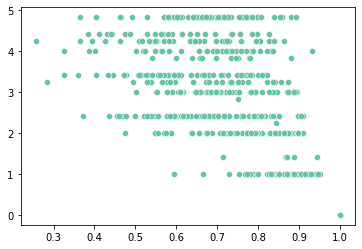

In [121]:
sns.scatterplot(x=changes[G_diff<5],y=G_diff[G_diff<5])

In [110]:
np.corrcoef(changes,G_diff)

array([[ 1.        , -0.49348974],
       [-0.49348974,  1.        ]])

In [111]:
np.corrcoef(changes[G_diff<50],G_diff[G_diff<50])

array([[ 1.        , -0.68186831],
       [-0.68186831,  1.        ]])

In [112]:
brc = Birch(n_clusters=32,threshold=0.5).fit(X)

lab=brc.labels_

In [113]:
metrics.silhouette_score(X, lab, metric='euclidean')

0.12184652

In [114]:
metrics.davies_bouldin_score(X, lab)

2.4191961671255027

In [115]:
d = euclidean_distances(X)

dunn.dunn(lab,d)

0.3419830285372551

<AxesSubplot:xlabel='x', ylabel='y'>

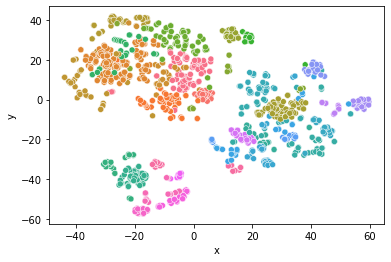

In [116]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

df = pd.DataFrame(np.concatenate((X_embedded[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
df["z"]=df["z"].astype("int").astype("str")
sns.scatterplot(data=df,x="x",y="y",hue="z", legend=None)

# optimizing

In [438]:
from joblib import Parallel, delayed

In [479]:
def mult_step(env,a):
    return env.step(a)

In [533]:
envs=[deepcopy(env) for i in range(6)]

In [546]:
n_cores = 6
parallel = Parallel(n_jobs=n_cores,backend='loky')

In [547]:
for env in envs:
    env.reset()

In [549]:
%time results = parallel(delayed(mult_step)(envs[i],0) for i in range(n_cores))

In [545]:
%%time
for env in envs:
    env.step(0)

CPU times: user 296 ms, sys: 3.97 ms, total: 300 ms
Wall time: 79.1 ms


In [136]:
X=env.object_list[0]

In [140]:
%timeit env.pca_obj.transform(X)

76.8 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [123]:
estimator=env.image_seg

In [124]:
from sklearn.utils import gen_batches
from joblib import Parallel, delayed

n_jobs = 6
n_samples, n_features = X.shape
batch_size = n_samples//n_jobs

def _predict(method, X, sl):
    return method(X[sl])

Parallel(n_jobs)(delayed(_predict)(estimator.predict, X, sl)
                 for sl in gen_batches(n_samples, batch_size))

[array([0, 3, 3, 0]),
 array([0, 6, 6, 6]),
 array([6, 6, 6, 6]),
 array([6, 6, 6, 7]),
 array([7, 7, 7, 7]),
 array([7, 7, 7, 7]),
 array([7])]

In [128]:
from copy import deepcopy

In [167]:
X=env.pca_list[100]

In [129]:
estimator_list=[deepcopy(estimator) for x in range(6)]

In [131]:
[sl for sl in gen_batches(n_samples, batch_size)]

[slice(0, 4, None),
 slice(4, 8, None),
 slice(8, 12, None),
 slice(12, 16, None),
 slice(16, 20, None),
 slice(20, 24, None),
 slice(24, 25, None)]

In [168]:
%timeit Parallel(n_jobs)(delayed(_predict)(estimator.predict, X, sl) for sl in gen_batches(n_samples, batch_size))

15.9 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [170]:
%timeit Parallel(6)(delayed(estimator_list[i].predict)(X[i::6,:]) for i in range(6))

12 ms ± 747 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
%timeit estimator.predict(X)

453 µs ± 7.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [174]:
%timeit env.preprocess_state(States[100])

10.9 ms ± 97.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# make model

In [157]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
#env    = OriginalFrame(env)
env    = ActionWrapper(env)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [38]:
env=gym.make('Pong-ramNoFrameskip-v4')
#env= OriginalFrame(env)
env=PongRamEnvironment(env)

In [991]:
model = DQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [992]:
model

DQN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [40]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

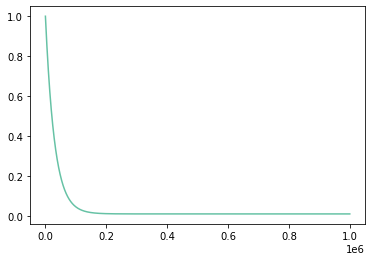

In [51]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

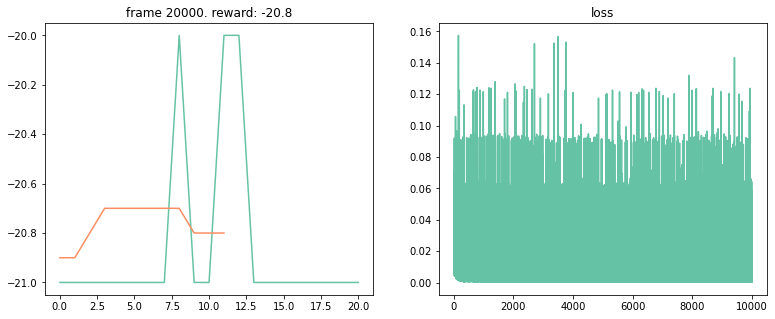

337.1681489927169 frames per sec


KeyboardInterrupt: 

In [185]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
tic = datetime.datetime.now()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        tac = datetime.datetime.now()
        print(str(10000/(tac-tic).total_seconds())+" frames per sec")
        tic = tac

In [168]:
(tac-tic).total_seconds()

0.0

In [189]:
torch.save(model, "model/my_model2.pt")

In [ ]:
model = torch.load(PATH)
model.eval()

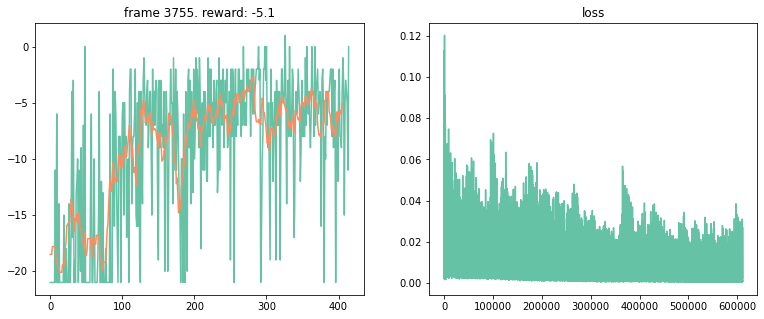

In [208]:
plot(frame_idx, all_rewards, losses)

In [19]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [371]:
USE_CUDA=True

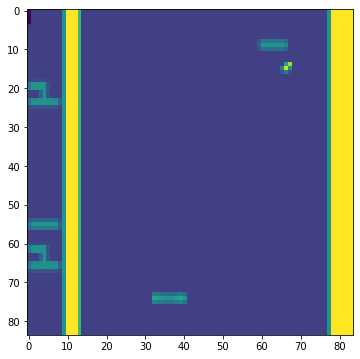

In [50]:
show_image(state_list[1])

In [41]:
class OriginalFrame(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.env=env
        self.orig_state_list=[]
        self.orig_action_list=[]
        self.orig_reward_list=[]

    def step(self, actions):
        state, reward, terminal, info = self.env.step(actions)
        self.orig_state_list.append(state)
        self.orig_action_list.append(action)
        self.orig_reward_list.append(reward)
        return state, reward, terminal, info

In [170]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = OriginalFrame(env)
env    = ActionWrapper(env)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [187]:
env=gym.make('Pong-ramNoFrameskip-v4')
env=PongRamEnvironment(env)
env=OriginalFrame(env)

In [188]:
state = env.reset()
episode_reward=0
for frame_idx in range(1, 10000):
    epsilon = 0.01
    action = model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    episode_reward += reward
    if done:
        state = env.reset()
        break

In [174]:
make_video(np.array(env.orig_state_list),name="meh",width=160,height=210)

# New algo

In [35]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state):
        with torch.no_grad():
            state   = Variable(torch.FloatTensor(state).unsqueeze(0))

        q_value = self.forward(state)
        action  = q_value.max(1)[1].item()
        return action

In [50]:
class PongRamEnvironment(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.repeat_action=4
        self.last_state=np.zeros(4)
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(8,), dtype=np.float32)
        self.action_space=spaces.Discrete(2)
        
    def preprocess_state(self, state):
        #cpu_score = ram[13]  # computer/ai opponent score 
        #player_score = ram[14]  # your score
        cpu_paddle_y = state[21]  # Y coordinate of computer paddle
        player_paddle_y = state[51]  # Y coordinate of your paddle
        ball_x = state[49]  # X coordinate of ball
        ball_y = state[54]  # Y coordinate of ball
        obs = np.array([cpu_paddle_y, player_paddle_y, ball_x, ball_y], dtype=np.float32)/255.0
        return obs


    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        state = np.zeros((2,4))
        self.last_state=np.zeros(4)
        return state.reshape(-1)

    def step(self, actions):
        
        #actions mapped
        actions={0:2,1:3}[actions]
        total_reward=0
        next_state=np.zeros((2,4))
        for i in range(self.repeat_action):
            state, reward, terminal, info = self.env.step(actions)
            total_reward += reward
            if terminal:
                break
        
        state=self.preprocess_state(state)
        next_state[0,:] = state
        next_state[1,:] = state-self.last_state
        self.last_state=state
        
        return next_state.reshape(-1), total_reward, terminal, info

In [59]:
model = DQN(2*env.observation_space.shape[0]+3+1, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [57]:
class ResetWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(0)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [58]:
env_start=gym.make('Pong-ramNoFrameskip-v4')
env_start=PongRamEnvironment(env_start)
env_map=MapWrapper(env_start,8,depth=3)
env=ResetWrapper(env_map)

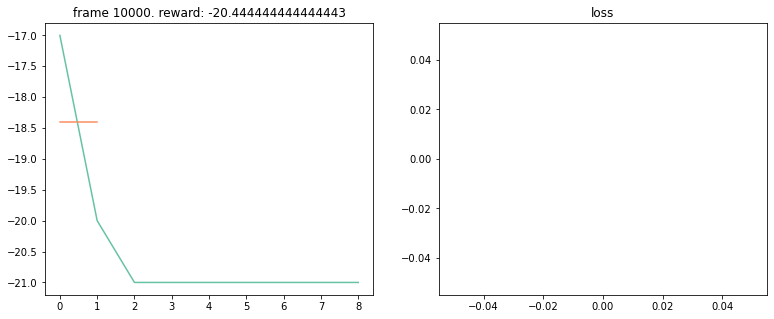

329.76966644062054 frames per sec


In [60]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

state = env_start.reset()
episode_reward=0
actions=[]
states=[]
rewards=[]

losses = []
all_rewards = []
episode_reward = 0
tic = datetime.datetime.now()

for frame_idx in range(1, num_frames + 1):
    epsilon=0
    states.append(state)
    if random.random() > epsilon:
        action = random.randrange(env.action_space.n)
        
    next_state, reward, done, _ = env_start.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    state = next_state[:env.observation_space.shape[0]]
    episode_reward += reward
    if done:
        print(frame_idx)
        state = env_start.reset()
        all_rewards.append(episode_reward)
        episode_reward=0
        env_map.state_map.update_map(states,actions,rewards)
        actions=[]
        states=[]
        rewards=[]
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        tac = datetime.datetime.now()
        print(str(10000/(tac-tic).total_seconds())+" frames per sec")
        tic = tac

In [61]:
len(env_map.state_map.G.nodes())

443

In [62]:
len(env_map.state_map.G.edges())

811

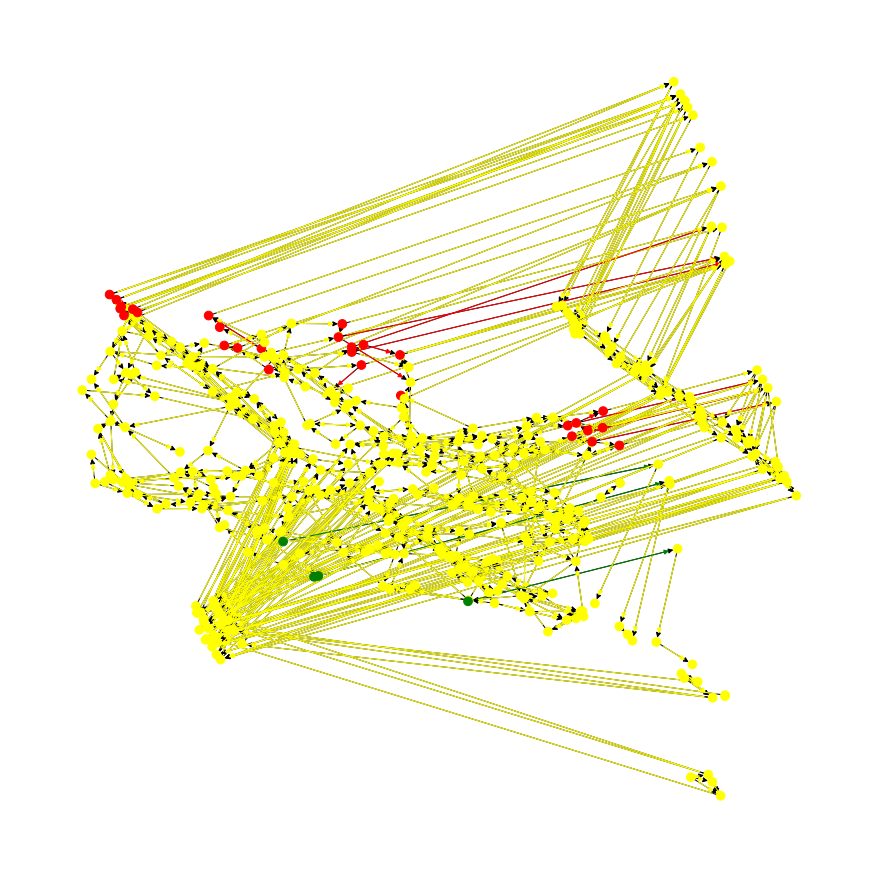

In [216]:
env_map.state_map.show_map()

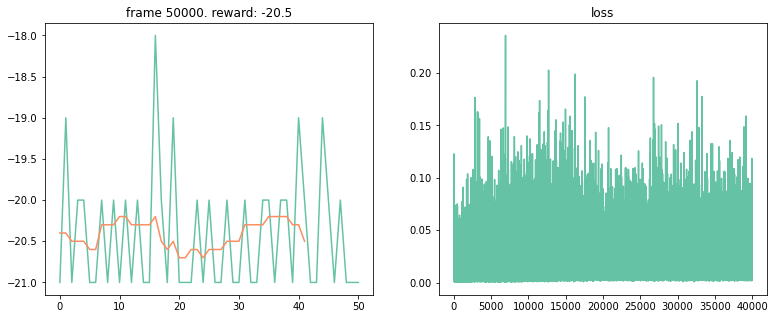

486.015416700627 frames per sec
50753


KeyboardInterrupt: 

In [123]:
num_frames = 100000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
tic = datetime.datetime.now()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    states.append(state)
    
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    rewards.append(reward)
    actions.append(action)
    
    state = next_state
    episode_reward += reward
    
    if done:
        print(frame_idx)
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        states=[s[:8] for s in states]
        env_map.state_map.update_map(states,actions,rewards)
        actions=[]
        states=[]
        rewards=[]
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        tac = datetime.datetime.now()
        print(str(10000/(tac-tic).total_seconds())+" frames per sec")
        tic = tac

In [ ]:
next_state, reward, done, _ = env_map.step(action)

In [195]:
%time env_map.step(0)

CPU times: user 52.3 ms, sys: 0 ns, total: 52.3 ms
Wall time: 16.2 ms


(array([ 5.09803951e-01,  1.80392161e-01,  5.09803951e-01,  5.09803951e-01,
         1.25490218e-01, -3.92156839e-03, -2.94117630e-01,  5.09803951e-01,
         6.43739402e-02,  3.97541039e-02,  6.25469983e-02,  6.56978339e-02,
         4.69312072e-05,  6.91035390e-03, -4.27998602e-04,  9.55820084e-04,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00]),
 0.0,
 False,
 {'lives': 0, 'episode_frame_number': 1300, 'frame_number': 119914})

In [44]:
class MapWrapper(gym.Wrapper):
    def __init__(self, env, dimensions,depth=4,action_n=2):
        gym.Wrapper.__init__(self, env)
        self.state_map=StateMap(dimensions,depth=depth,action_n=action_n)
        
    def preprocess_state(self, state):
        current_node, best_path, best_scenario_ind, predicted_next_states = self.state_map.propose_path(state)
        best=predicted_next_states[best_scenario_ind[0]]
        new_state=np.concatenate((state,best[0],np.array(best[1]),[best[2]]))
        return new_state
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        new_state=self.preprocess_state(orig_state)
        next_state=new_state
        return next_state, reward, terminal, info

In [45]:
def weights_adjust(d):
    w=d['weight']
    if w==0:
        return 1
    if w==-1:
        return 100
    if w==1:
        return 0

In [46]:
class StateMap():
    def __init__(self,dimensions,depth=4,action_n=2):
        self.dimensions=dimensions
        self.action_n=action_n
        self.depth=depth
        self.node_brc=Birch(n_clusters=None,threshold=0.01,branching_factor=100)
        self.edge_brc=Birch(n_clusters=None,threshold=0.01,branching_factor=100)
        self.pred_reward=HoeffdingTreeClassifier(nominal_attributes=[self.dimensions])
        self.pred_state=Net_Regr(self.dimensions+1,self.dimensions//2)
        self.G=nx.DiGraph()
        self.current_node=None
        self.best_path=[]
        
    def update_map(self,states,actions,rewards):
        
        D=self.dimensions
        states_now=np.array(states)[1:-1]/D
        states_next=np.array(states)[2:]/D
        reward_now=np.array(rewards[1:-1]).reshape(-1).astype(int)
        act_now=np.array(actions[1:-1]).astype(int)
        
        state_action=np.hstack((states_now,act_now.reshape(-1,1)))
        state_pair=np.hstack((states_now,act_now.reshape(-1,1),reward_now.reshape(-1,1),states_next))
        #train reward prediction
        self.pred_reward.partial_fit(state_action,reward_now+1,sample_weight=1+9*np.abs(reward_now))
        #train state prediction
        self.pred_state.train(state_action,states_next[:,:D//2],epochs=50)
        
        self.edge_brc.partial_fit(state_pair)
        
        self.node_brc.partial_fit(states_now)
        
        lab=self.node_brc.subcluster_labels_
        
        N_E=self.edge_brc.subcluster_centers_.shape[0]
        N_N=self.node_brc.subcluster_centers_.shape[0]
        
        #rebuild graph
        self.G=nx.DiGraph()
        for i in range(N_N):
            self.G.add_nodes_from([(lab[i], {'position':self.node_brc.subcluster_centers_[lab[i]],'value':0})])
        
        for i in range(N_E):
            l=self.node_brc.predict([self.edge_brc.subcluster_centers_[i,:D]])[0]
            r=self.node_brc.predict([self.edge_brc.subcluster_centers_[i,-D:]])[0]
            w=int(self.edge_brc.subcluster_centers_[i,D+1])
            a=int(self.edge_brc.subcluster_centers_[i,D])
            self.G.add_edge(l,r,weight=w,action=a)
            
            if w!=0:
                self.G.add_nodes_from([(l, {'position':self.node_brc.subcluster_centers_[l],'value':w})])

        #remove self loops
        self.G.remove_edges_from(list(nx.selfloop_edges(self.G)))
        self.current_node=None
        self.best_path=[]
            
    def predict_reward(self,state,action):
        state_action=np.hstack((state,action))
        return self.pred_reward.predict([state_action])[0]-1
    
    def predict_state(self,state,action):
        state_action=np.hstack((state,action))
        return self.pred_state.predict([state_action]).reshape(-1)
    
    def pred_multi_step(self, state, depth=3):

        def _pred(self,state, depth,action_seq,total_reward):
            predicted_next_states=[self.predict_state(state,a) for a in range(self.action_n)]
            predicted_next_states=[np.concatenate((predicted_next_states[a], predicted_next_states[a]-state[:self.dimensions//2]), axis=-1) for a in range(self.action_n)]
            predicted_next_rewards=[self.predict_reward(state,a) for a in range(self.action_n)]
            if depth==1:
                return [(predicted_next_states[a], action_seq+[a], total_reward+predicted_next_rewards[a]) for a in range(self.action_n)]
            else:
                return [_pred(self, predicted_next_states[a], depth-1, action_seq+[a],total_reward+predicted_next_rewards[a]) for a in range(self.action_n)]

        return flatten_list(_pred(self, state, depth,action_seq=[],total_reward=0))

    def get_path_index(self,state):
        try:
            index = self.best_path.index(self.node_brc.predict([state])[0])
        except ValueError:
            index = -1

        return index
    
    def propose_path(self,state, env=None):
        state=state/self.dimensions
        self.current_node=self.node_brc.predict([state])[0]
        #check if path is followed
        if self.current_node not in self.best_path[:-1]:
            good=[n for n in self.G.nodes() if self.G.nodes()[n]['value']==1]
            l,p=nx.single_source_dijkstra(self.G,self.current_node,weight = lambda u, v, d: weights_adjust(d),cutoff=50)
            candidates=np.array([g for g in good if g in l])
#             print(candidates)
            if len(candidates)>0:
                best=np.array([l[g] for g in candidates]).argmin()
                self.best_path=p[candidates[best]]
            else:
                self.best_path=[self.current_node]
        
#         print(self.best_path)
#         print(self.current_node)
        i=self.best_path.index(self.current_node)
        
        if len(self.best_path)>1:
            proposed_next_state=self.node_brc.subcluster_centers_[self.best_path[i+1]]
            proposed_final_state=self.node_brc.subcluster_centers_[self.best_path[-1]]
        else:
            proposed_next_state=self.node_brc.subcluster_centers_[self.best_path[i]]
            proposed_final_state=self.node_brc.subcluster_centers_[self.best_path[-1]]
            
        if env is None:
            predicted_next_states=self.pred_multi_step(state,depth=self.depth)
        else:
            predicted_next_states=pred_true_multi_step(state, env, action_n=self.action_n, depth=self.depth)

        a=np.array([[self.get_path_index(s[0]),mean_squared_error(proposed_final_state,s[0]),s[2]] for s in predicted_next_states])
        best_scenario_ind=np.lexsort((a[:,1], a[:,0][::-1], a[:,2][::-1]))
        
        return self.current_node, self.best_path, best_scenario_ind, predicted_next_states
        
    def show_map(self, nodes_to_draw=None, show_labels=False, state1=None, state2=None):
        pca=PCA(2)
        pca.fit(self.node_brc.subcluster_centers_)
        
        H=deepcopy(self.G)
        
        def map_c(x):
            if x==-1:
                return "red"
            if x==0:
                return "yellow"
            if x==1:
                return "green"
            if x==2:
                return "blue"
            if x==3:
                return "orange"
        
        if state1 is not None:
            H.add_nodes_from([(-1, {'position':state1,'value':2})])
            if nodes_to_draw is not None:
                nodes_to_draw.append(-1)
            
        if state2 is not None:
            H.add_nodes_from([(-2, {'position':state2,'value':3})])
            if nodes_to_draw is not None:
                nodes_to_draw.append(-2)
        
        if nodes_to_draw is not None:
            H=H.subgraph(nodes_to_draw)
        
        
        edges = H.edges()
        colors = [map_c(H[u][v]['weight']) for u,v in edges]
        weights = [H[u][v]['weight'] for u,v in edges]

        color_map = []
        for n in H.nodes():
            color_map.append(int(H.nodes()[n]["value"]))
        
        color_map=[map_c(x) for x in color_map]
        pos = nx.spring_layout(H)
        for n in H.nodes():
            pos[n][0]=pca.transform([H.nodes[n]['position']])[0][0]
            pos[n][1]=pca.transform([H.nodes[n]['position']])[0][1]

        plt.figure(figsize=(12,12))
        ec = nx.draw(H, pos, node_color=color_map,node_size=75,with_labels=show_labels)
        nx.draw_networkx_edges(H, pos, edge_color=colors)
#         plt.show()

In [47]:
def pred_true_multi_step(state, env, action_n=2, depth=3):

    def _pred(state, env, action_n, game_state, depth, action_seq, total_reward):
        env.unwrapped.restore_full_state(game_state)
        predicted_next_states=[]
        predicted_next_rewards=[]
        predicted_next_game_states=[]
        for a in range(action_n):
            new_state, reward, _, _=env.step(a)
            new_game_state=env.unwrapped.clone_full_state()
            predicted_next_game_states+=[new_game_state]
            new_state[len(state)//2:]=new_state[:len(state)//2]-state[:len(state)//2]
            predicted_next_states+=[new_state]
            predicted_next_rewards+=[reward]
            env.unwrapped.restore_full_state(game_state)
        
        if depth==1:
            return [(predicted_next_states[a], action_seq+[a], total_reward+predicted_next_rewards[a]) for a in range(action_n)]
        else:
            return [_pred(predicted_next_states[a], env, action_n, predicted_next_game_states[a], depth-1, action_seq+[a],total_reward+predicted_next_rewards[a]) for a in range(action_n)]

    game_state=env.unwrapped.clone_full_state()
    results=flatten_list(_pred(state, env, action_n, game_state, depth,action_seq=[],total_reward=0))
    env.unwrapped.restore_full_state(game_state)
    return results

In [48]:
def RAM_to_image(ram):
    img=np.zeros([84,84,3])
    img[int(84*ram[0]):int(84*ram[0])+6,20:22,:]=1
    img[int(84*ram[1]):int(84*ram[1])+6,-22:-20,:]=1
    img[int(84*ram[3]):int(84*ram[3])+1,int(84*ram[2]):int(84*ram[2])+1,:]=1
    return img

In [49]:
env_map.state_map.update_map(states,actions,rewards)

NameError: name 'env_map' is not defined

In [187]:
env_map.state_map.G.degree

DiDegreeView({0: 1, 1: 2, 2: 2, 3: 3, 4: 2})

In [217]:
len(env_map.state_map.G.nodes())

423

In [218]:
len(env_map.state_map.G.edges())

846

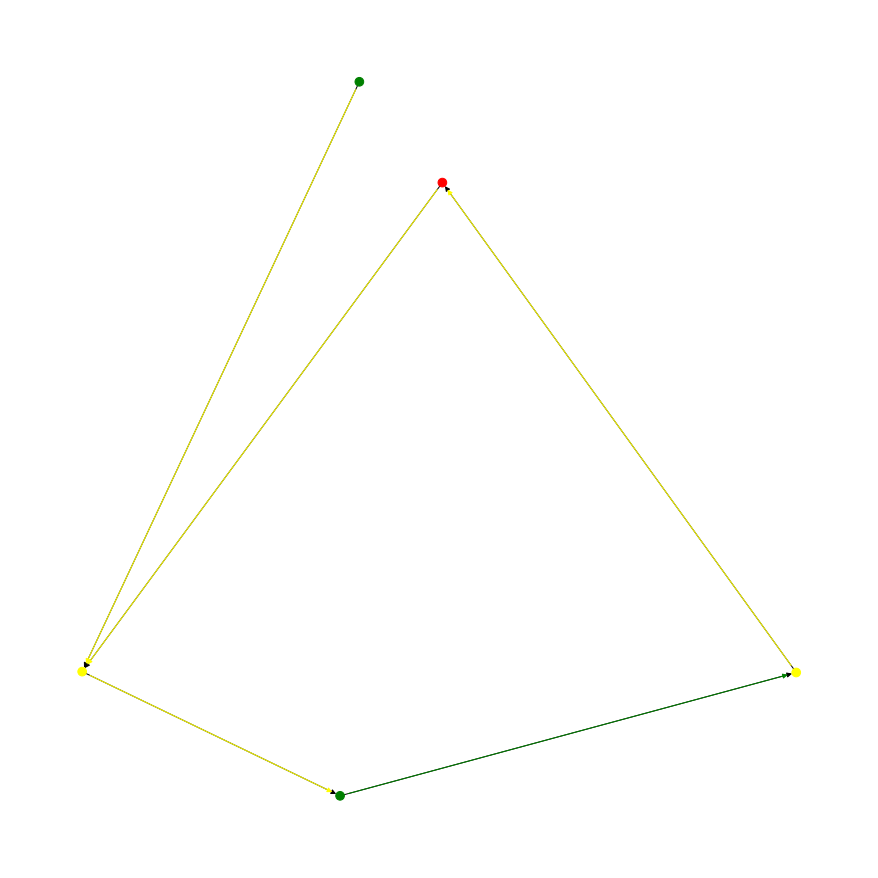

In [204]:
env_map.state_map.show_map()

In [653]:
env1=gym.make('Pong-ramNoFrameskip-v4')
env1=PongRamEnvironment(env1)
env1.reset()
for i in range(15):
    val=env1.step(1)

In [654]:
new_game_state1=env1.unwrapped.clone_full_state()

for i in range(5):
    val1=env1.step(1)

new_game_state2=env1.unwrapped.clone_full_state()

env1.unwrapped.restore_state(new_game_state1)

new_game_state3=env1.unwrapped.clone_full_state()

for i in range(5):
    val2=env1.step(1)

new_game_state4=env1.unwrapped.clone_full_state()

env1.unwrapped.restore_state(new_game_state3)

In [655]:
new_game_state1.equals(new_game_state3)

True

In [656]:
new_game_state2.equals(new_game_state4)

True

In [657]:
val

(array([0.50980395, 0.79607844, 0.49411765, 0.50980395, 0.50980395,
        0.        , 0.49411765, 0.50980395]),
 0.0,
 False,
 {'lives': 0, 'episode_frame_number': 60, 'frame_number': 60})

In [986]:
np.concatenate((val1[0],predi[0],np.array(predi[1]),[predi[2]]))

array([ 0.58823532,  0.79607844,  0.41568628,  0.58823532,  0.01568627,
        0.        , -0.01568627,  0.01568627,  0.58823532,  0.79607844,
        0.41568628,  0.58823532,  0.01568627,  0.        , -0.01568627,
        0.01568627,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.        ])

In [977]:
predi

(array([ 0.58823532,  0.79607844,  0.41568628,  0.58823532,  0.01568627,
         0.        , -0.01568627,  0.01568627]),
 [1, 1, 1, 1, 1],
 0.0)

In [662]:
val1[0]

array([ 0.58823532,  0.79607844,  0.41568628,  0.58823532,  0.01568627,
        0.        , -0.01568627,  0.01568627])

In [663]:
predi=pred_true_multi_step(val[0],env1,depth=5)[-1]

(predi[0]-val1[0]).mean()

0.0

In [664]:
(predi[0]-val2[0]).mean()

0.0

In [665]:
(val1[0]-val2[0]).mean()

0.0

In [473]:
state=env.step(0)[0]

In [474]:
state

array([ 0.24313726,  0.14901961,  0.76078433,  0.24313726, -0.01568629,
        0.        ,  0.01568627, -0.01568629])

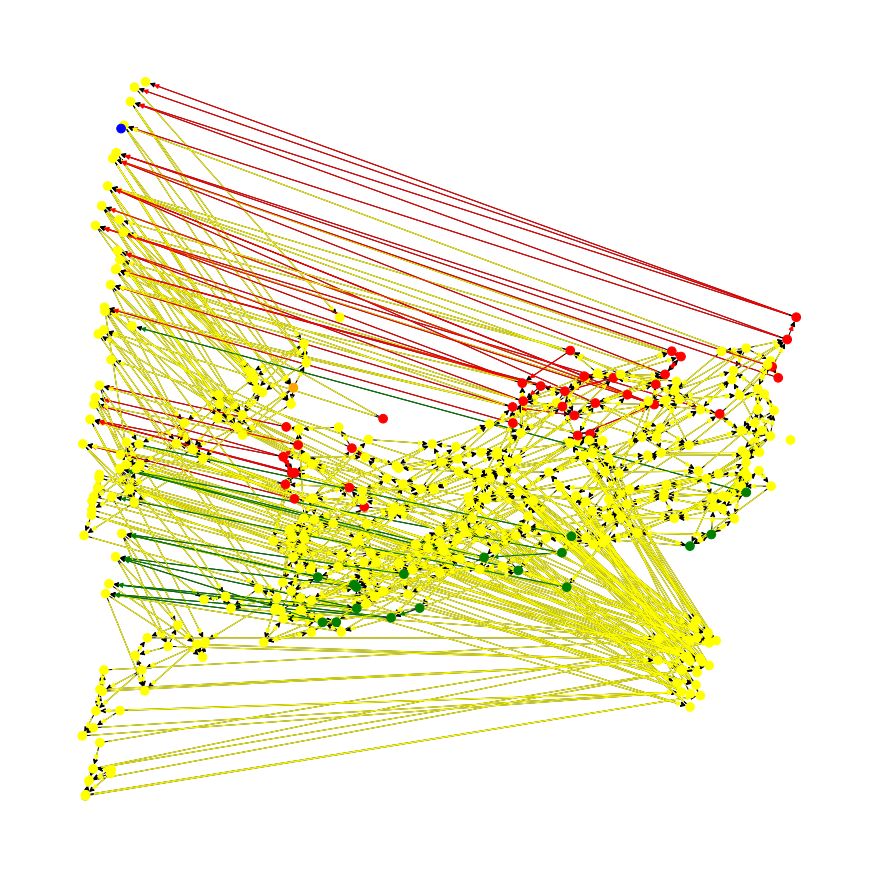

In [585]:
i=100
node,path,proposed_next_action, proposed_next_state, prediction=state_map.propose_path(states[i])
state_map.show_map(state1=states[i],state2=proposed_next_state)

In [54]:
class Net_Regr(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net_Regr, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.criterion = nn.MSELoss()
        
    def forward(self, X):
        X  = autograd.Variable(torch.FloatTensor(X))
        return self.layers(X)
    
    def predict(self, X):
        X  = autograd.Variable(torch.FloatTensor(X))
        return self.layers(X).detach().numpy()
    
    def train(self, X, y, epochs=100, batch_size = 128):
        y=torch.FloatTensor(y)
        
        permutation = torch.randperm(X.shape[0])
        
        for e in range(epochs):
            
            for i in range(0,X.shape[0], batch_size):
                self.optimizer.zero_grad()
                
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X[indices], y[indices]
        
                y_hat = self.forward(batch_x)
                loss = self.criterion(y_hat, batch_y)
                loss.backward()
                self.optimizer.step()
                    
        return loss

In [55]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score, mean_absolute_error

In [135]:
int(env_map.preprocess_state(state[:8])[16])

1

In [63]:
%%time
num_frames = 100000
batch_size = 32
gamma      = 0.99

state = env.reset()[:8]
episode_reward=0
actions=[]
states=[]
rewards=[]
game_states=[]

losses = []
all_rewards = []
episode_reward = 0

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    epsilon=1
    states.append(state)
    
    proposed_next_action=int(env_map.preprocess_state(state)[16])
    
    if random.random() > epsilon:
        action = random.randrange(env.action_space.n)
    else:
        action = proposed_next_action
        
    next_state, reward, done, _ = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    state = next_state[:8]
    episode_reward += reward
    if done:
        print(frame_idx)
        print(episode_reward)
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward=0
        break

824
-21.0
CPU times: user 1min 4s, sys: 2.34 s, total: 1min 7s
Wall time: 22.2 s


In [158]:
fail=np.where(reward_now==-1)[0]

In [161]:
env_map.state_map.propose_path(states[fail[6]-3],env=None)

(83,
 [83, 302, 242, 79, 19, 18],
 array([5, 6, 7, 4, 3, 2, 1, 0]),
 [(array([ 0.57074398,  0.63474387,  0.78238475,  0.59856874,  0.02571833,
          -0.06488729,  0.01706564,  0.018067  ]),
   [0, 0, 0],
   -2),
  (array([5.75499415e-01, 7.04382777e-01, 7.77932107e-01, 5.81147671e-01,
          3.04737687e-02, 4.75162268e-03, 1.26129985e-02, 6.45935535e-04]),
   [0, 0, 1],
   -2),
  (array([ 0.58172679,  0.72012776,  0.77143955,  0.58781642,  0.02819467,
          -0.03282976,  0.01008707,  0.0142225 ]),
   [0, 1, 0],
   -2),
  (array([0.58570391, 0.76833063, 0.76911944, 0.57841384, 0.03217179,
          0.01537311, 0.00776696, 0.00481993]),
   [0, 1, 1],
   -2),
  (array([ 0.58162397,  0.71042961,  0.76573783,  0.58669853,  0.02595109,
          -0.05399442,  0.00739533,  0.01745558]),
   [1, 0, 0],
   -1),
  (array([5.86519182e-01, 7.64701366e-01, 7.62395740e-01, 5.79899609e-01,
          3.08462977e-02, 2.77340412e-04, 4.05323505e-03, 1.06566548e-02]),
   [1, 0, 1],
   -1),
  (a

In [932]:
win=np.where(reward_now==1)[0]

In [933]:
win

array([], dtype=int64)

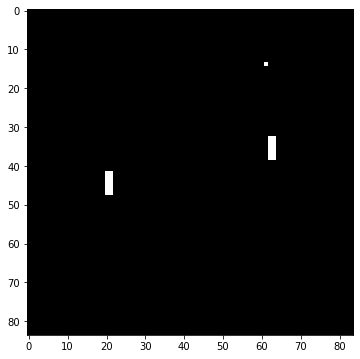

In [934]:
show_image(RAM_to_image(xd[0][0]))

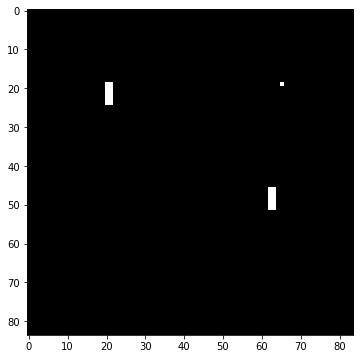

In [958]:
show_image(states_img[fail[6]])

In [162]:
states_img=np.array([RAM_to_image(s) for s in states])

make_video((states_img*255).astype(np.uint8),name="test",width=84,height=84,channel=3,fps=30)

In [64]:
states_now=np.array(states)[1:-1]
states_next=np.array(states)[2:][:,:4]
reward_now=np.array(rewards[1:-1]).reshape(-1).astype(int)
act_now=np.array(actions[1:-1]).astype(int)
state_action=np.hstack((states_now,act_now.reshape(-1,1)))

In [70]:
act0=act_now==0

In [71]:
reg = LinearRegression().fit(state_action[act0], states_next[act0])

In [144]:
# net=Net_Regr(9,4)

# net.train(state_action, states_next,1000,128)

In [145]:
net=env_map.state_map.pred_state

In [72]:
mean_absolute_error(reg.predict(state_action),states_next)

0.047222072294889894

In [147]:
state_map.update_map(states_now,act_now,reward_now)

In [73]:
mean_absolute_error(net.predict(state_action),states_next)

NameError: name 'net' is not defined

In [149]:
r2_score(states_next,net.predict(state_action))

0.9292856173196842

In [74]:
r2_score(states_next[act0],reg.predict(state_action[act0]))

0.9028608447032309

In [151]:
mean_squared_error(reg.predict(state_action),states_next)

0.0024467986180697955

In [152]:
mean_squared_error(net.predict(state_action),states_next)

0.0028549598001268916

In [154]:
reward=reward_now

np.mean(env_map.state_map.pred_reward.predict(state_action)-1==reward.reshape(-1).astype(int))

1.0

In [156]:
reward_pred=env_map.state_map.pred_reward.predict(state_action)-1

for x in np.unique(reward):
    print(str(x)+":"+str(np.mean(reward_pred[reward_pred==x]==reward[reward_pred==x]))+" N:"+str(np.sum(reward_pred==x)))

-1:1.0 N:21
0:1.0 N:1941


In [163]:
2000000/60/3600

9.25925925925926